# Utilizing Expert Knowledge

The data uses this scenario.

In New York, Citi Bike operates a network of bicycle rental stations with a subscription
system. The stations are all over the city and provide a convenient way to get
around. Bike rental data is made public in an anonymized form and has been analyzed
in various ways. The task we want to solve is to predict for a given time and day
how many people will rent a bike in front of Andreas’s house—so he knows if any
bikes will be left for him.

In [1]:
import mglearn

# import the city bike datasets
citibike = mglearn.datasets.load_citibike()

citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

Text(0, 0.5, 'Rentals')

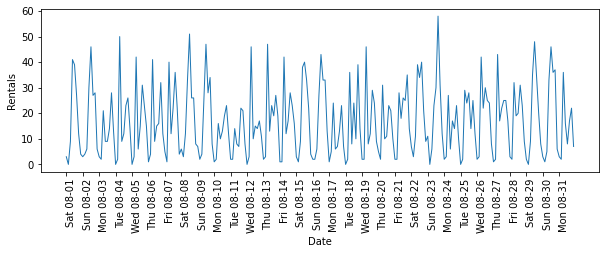

In [5]:
# visualizing the data
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10,3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

In [10]:
# preparing the data
y = citibike.values
# converting to POSIX time by dividing by 10**9
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [19]:
from sklearn.model_selection import train_test_split

# define number of training
n_train = 184

# create a function for train, test, and visualize the model
def eval_on_features(features, target, regressor):
    # split the train and test data
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    # fit the model
    regressor.fit(X_train, y_train)
    print("R^2 score : {:.2f}".format(regressor.score(X_test, y_test)))
    # predict the train and test data
    y_train_predict = regressor.predict(X_train)
    y_test_predict = regressor.predict(X_test)

    # visuallizing the data
    plt.figure(figsize=(10, 3))
    xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
    plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test,'-', label="test")

    plt.plot(range(n_train), y_train_predict, '--', label="training predicition")
    plt.plot(range(n_train, len(y_test) + n_train), y_test_predict, '--',
            label="test prediction")

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Rentals")

R^2 score : -0.04


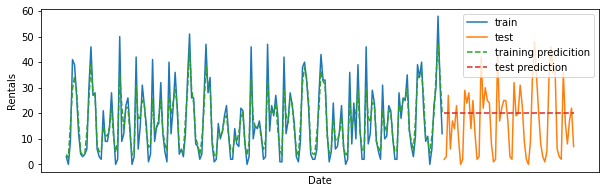

In [20]:
# First, trying with RandomforestRegressor
# since it doesn't need much preprocessing
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
# call our evaluation function
eval_on_features(X, y, regressor)

R^2 score : 0.60


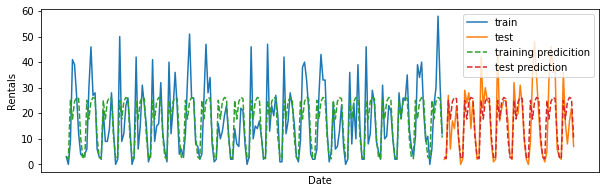

In [22]:
# the test did not score well, because
# the test features is outside the train since it uses POSIX time.
# Now by using our knowledge of the data lets improve the features 
# by extracting the hour
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

[[ 5  0]
 [ 5  3]
 [ 5  6]
 [ 5  9]
 [ 5 12]
 [ 5 15]
 [ 5 18]
 [ 5 21]
 [ 6  0]
 [ 6  3]]
R^2 score : 0.84


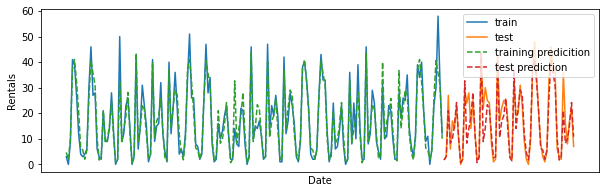

In [27]:
# now adding the day of week into our regressor
# since the previous attempe done well
import numpy as np
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1,1),
                citibike.index.hour.values.reshape(-1, 1)])
print(X_hour_week[: 10])
eval_on_features(X_hour_week, y, regressor)

R^2 score : 0.13


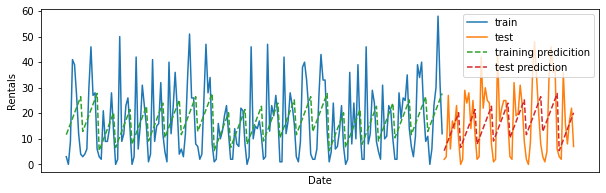

In [28]:
# we can also model this using Linear models
# since it's much simpler than RandomForest
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
eval_on_features(X_hour_week, y, regressor)

R^2 score : 0.62


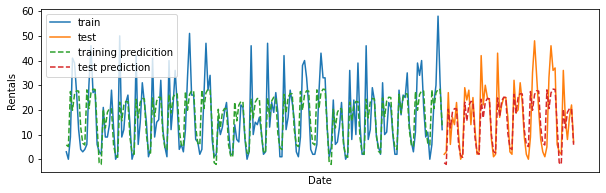

In [32]:
# the result is odd
# seems like the model needs more complex features
# to make it fit
# and becayse of the day is integer linear model
# cannot understand it since its not linear
# therefore we can encode the day using one hot encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

# using LinearRegression or Ridge gives the same result

R^2 score : 0.85


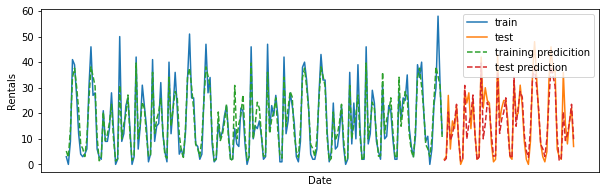

In [34]:
# the result gets better
# now the models learned one coefficient
# for a week and one coefficient for a day
# this means the "time of day" is shared
# over all of the week (the pattern at monday
# is shared for all of the monday)
# since we've already learn interaction and
# polynomials we can implement this
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True,
        include_bias=False)
X_hour_week_onehot_poly = poly.fit_transform(X_hour_week_onehot)
regressor = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, regressor)

# finally the linear model perform like Randomforest

Text(0, 0.5, 'Feature magnitude')

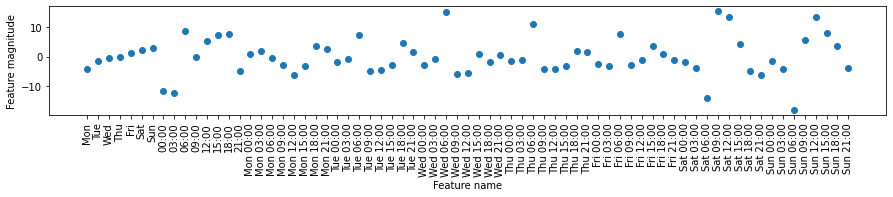

In [37]:
# we can get the coefficents from linear models
# one big benefit of linear model is we can get
# the things learn by the model
hour = ["%02d:00" % i for i in range(0,24,3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

# extract all the coefficients from Poly and filter the zeros
features_poly = poly.get_feature_names(features)
features_nonzero = np.array(features_poly)[regressor.coef_ != 0]
coef_nonzero = regressor.coef_[regressor.coef_ != 0]

# visualize the coefficients
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")